# Facial Expression Recognition

In [5]:
%matplotlib inline
from random import randint
import csv
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

### Read CSV
We need to read the input data from CSV. We are not separating training data and test data yet.

In [38]:
# Feature Vectors
imgs_train = []
imgs_test = []
# Labels (0-1)
labels = []

with open('fer2013.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    # skip CSV header
    next(readCSV)
    for row in readCSV:
        label = int(row[0])
        labels.append(label)
        if row[2] == 'Training':
            # cast pixels to int
            pixels_train = [float(x) for x in row[1].split(' ')]
            imgs_train.append(np.array(pixels_train))
        elif row[2] == 'PublicTest':
            pixels_test = [float(x) for x in row[1].split(' ')]
            imgs_test.append(np.array(pixels_test))

### Data Dimensions
The data dimensions are used in several places in the source-code below. They are defined once so we can use these variables instead of numbers throughout the source-code below.

In [7]:
# images are 48 pixels in each dimension.
img_size = 48

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes.
num_classes = 7

### Data Preview
Let's see some random images from the training set along with their labels.
#### Labels
0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral


4


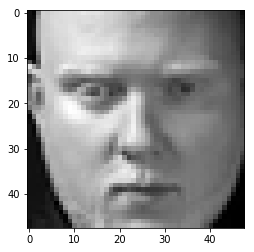

In [31]:
i = randint(0, len(imgs_train))
image = np.array(imgs_train[i]).reshape(img_shape)
plt.imshow(image, cmap='gray')
print(labels[i])

### Plotting Images and Classes
This helper function prints nine images along with the corresponsing true and predicted classes.

In [32]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='gray')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

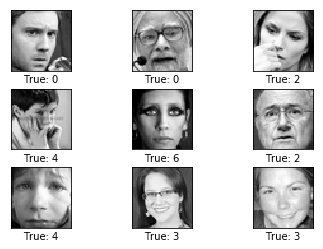

In [43]:
# Get the first images from the train-set.
images = imgs_train[0:9]

# Get the true classes for those images.
cls_true = labels[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

### Tensorflow Estimator API
Let's define an input function that returns the data to the Estimator.

In [119]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": np.array(imgs_train)},
    y=np.array(labels),
    num_epochs=None,
    shuffle=True)

In [122]:
train_input_fn()

({'x': <tf.Tensor 'random_shuffle_queue_DequeueMany_1:1' shape=(128, 2304) dtype=float64>},
 <tf.Tensor 'random_shuffle_queue_DequeueMany_1:2' shape=(128,) dtype=int64>)

Also, we need to define an input function for the test-data input.